# Visualize protein deformability

Protein Blocks are great tools to study protein deformability. Indeed, if the block assigned to a residue changes between two frames of a trajectory, it represents a local deformation of the protein rather than the displacement of the residue.

The API allows to visualize Protein Block variability throughout a molecular dynamics simulation trajectory.

In [1]:
from pprint import pprint
from IPython.display import Image, display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import urllib.request
import os
import numpy as np

# print date & versions
import datetime
print("Date & time:",datetime.datetime.now())
import sys
print("Python version:", sys.version)
print("Matplotlib version:", matplotlib.__version__)

Date & time: 2017-10-03 14:53:52.137511
Python version: 3.5.2 (default, Nov 17 2016, 17:05:23) 
[GCC 5.4.0 20160609]
Matplotlib version: 2.0.2


In [2]:
import pbxplore as pbx
print("PBxplore version:", pbx.__version__)

PBxplore version: 1.3.7


Here we will look at a molecular dynamics simulation of the barstar. As we will analyse Protein Block sequences, we first need to assign these sequences for each frame of the trajectory.

In [3]:
# Assign PB sequences for all frames of a trajectory
topology, _ = urllib.request.urlretrieve('https://raw.githubusercontent.com/pierrepo/PBxplore/master/demo_doc/psi_md_traj.gro', 
                                         'psi_md_traj.gro')
trajectory, _ = urllib.request.urlretrieve('https://raw.githubusercontent.com/pierrepo/PBxplore/master/demo_doc/psi_md_traj.xtc', 
                                           'psi_md_traj.xtc')
sequences = []
for chain_name, chain in pbx.chains_from_trajectory(trajectory, topology):
    dihedrals = chain.get_phi_psi_angles()
    pb_seq = pbx.assign(dihedrals)
    sequences.append(pb_seq)

/ibpc/sablons/santuz/.virtualenvs/pbxplore_py3/lib/python3.5/site-packages/MDAnalysis/coordinates/XDR.py:189: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "
Frame 1/225.
Frame 100/225.
Frame 200/225.
Frame 225/225.


## Block occurences per position

The basic information we need to analyse protein deformability is the count of occurences of each PB for each position throughout the trajectory. This occurence matrix can be calculated with the `pbxplore.analysis.count_matrix()` function.

In [4]:
count_matrix = pbx.analysis.count_matrix(sequences)

``count_matrix`` is a numpy array with one row per PB and one column per position. In each cell is the number of time a position was assigned to a PB.

We can visualize ``count_matrix`` using Matplotlib as any 2D numpy array.

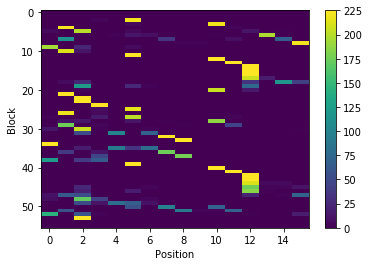

In [5]:
im = plt.imshow(count_matrix, interpolation='none', aspect='auto')
plt.colorbar(im)
plt.xlabel('Position')
plt.ylabel('Block')

PBxplore provides the `pbxplore.analysis.plot_map()` function to ease the visualization of the occurence matrix.

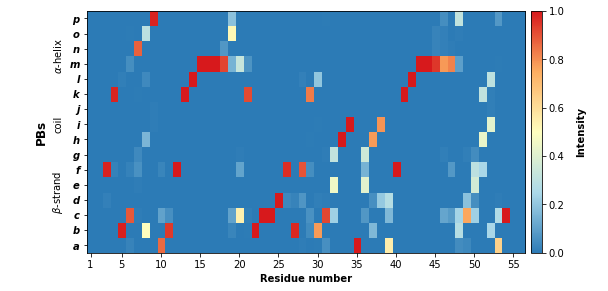

In [6]:
pbx.analysis.plot_map('map.png', count_matrix)
!rm map.png

The `pbxplore.analysis.plot_map()` helper has a ``residue_min`` and a ``residue_max`` optional arguments to display only part of the matrix. These two arguments can be pass to all PBxplore functions that produce a figure.

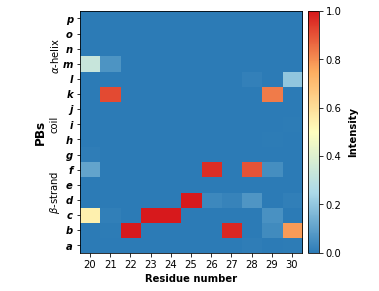

In [7]:
pbx.analysis.plot_map('map.png', count_matrix,
                      residue_min=20, residue_max=30)
!rm map.png

Note that matrix in the the figure produced by `pbxplore.analysis.plot_map()` is normalized so as the sum of each column is 1. The matrix can be normalized with the `pbxplore.analysis.compute_freq_matrix()`.

In [8]:
freq_matrix = pbx.analysis.compute_freq_matrix(count_matrix)

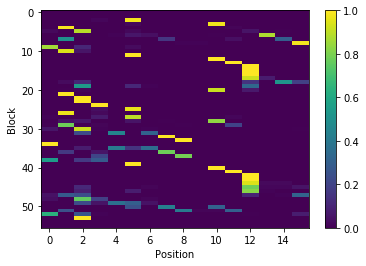

In [9]:
im = plt.imshow(freq_matrix, interpolation='none', aspect='auto')
plt.colorbar(im)
plt.xlabel('Position')
plt.ylabel('Block')

## Protein Block entropy

The $N_{eq}$ is a measure of variability based on the count matrix calculated above. It can be computed with the `pbxplore.analysis.compute_neq()` function.

In [10]:
neq_by_position = pbx.analysis.compute_neq(count_matrix)

``neq_by_position`` is a 1D numpy array with the $N_{eq}$ for each residue.

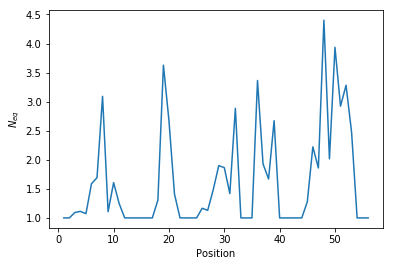

In [11]:
#Residus start by default at 1.
resids = np.arange(1,len(neq_by_position)+1)

plt.plot(resids, neq_by_position)
plt.xlabel('Position')
plt.ylabel('$N_{eq}$')

The `pbxplore.analysis.plot_neq()` helper ease the plotting of the $N_{eq}$.

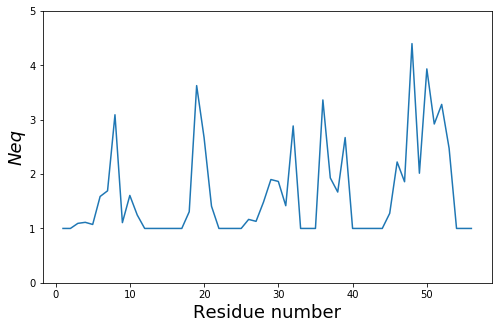

In [12]:
pbx.analysis.plot_neq('neq.png', neq_by_position)
!rm neq.png

The ``residue_min`` and ``residue_max`` arguments are available.

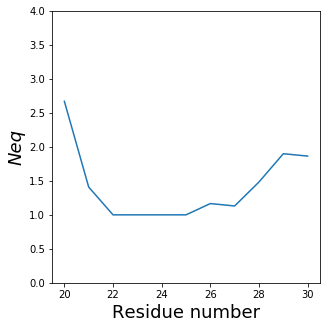

In [13]:
pbx.analysis.plot_neq('neq.png', neq_by_position,
                      residue_min=20, residue_max=30)
!rm neq.png

### Neq with RMSF

The $N_{eq}$ and RMSF (Root Mean Square Fluctuation) can be plot together to highlight differences between flexible and rigid residues : the $N_{eq}$ is a metric of deformability and flexibility whereas RMSF quantifies mobility.

Here an example of a plot with both metrics (You can adapt this code to your own need):

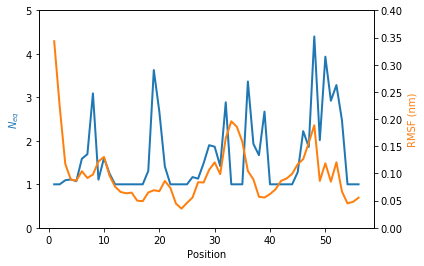

In [14]:
# Let's assume you computed the RMSF (file rmsf.xvg)
# For this example, the rmsf was computed on the C-alpha and grouped by residue :
# g_rmsf -s psi_md_traj.gro -f psi_md_traj.xtc -res -o rmsf.xvg (Gromacs 4.6.7)


# Read rmsf file (ignore lines which start by '#@' and assume the data are in 2-column,
# first one the number of residue, 2nd one the rmsf
rmsf = np.array([line.split() for line in open("../../../demo_doc/rmsf.xvg") if not line[0] in '#@'], dtype=float)

#Generate 2 y-axes who share a same x-axis
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#Left Axis
ax1.plot(rmsf[:,0], neq_by_position, color='#1f77b4', lw=2)
ax1.set_xlabel('Position')
ax1.set_ylabel('$N_{eq}$', color='#1f77b4')
ax1.set_ylim([0.0, 5])

#Right Axis
ax2.plot(rmsf[:,0], rmsf[:,1],color='#ff7f0e', lw=2)
ax2.set_ylim([0.0, 0.4])
ax2.set_ylabel('RMSF (nm)', color='#ff7f0e')


We observe that the region 33-35 is rigid. 
The high values of RMSF we observed  were due to flexible residues in the vicinity of the region 33-35, probably acting as hinges (residues 32 and 36--37).
Those hinges, due to their flexibility, induced the mobility of the whole loop : the region 33-35 fluctuated but did not deform.

## Display PB variability as a logo

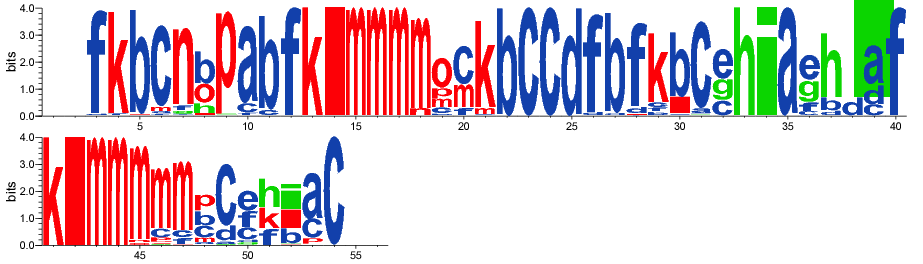

In [15]:
pbx.analysis.generate_weblogo('logo.png', count_matrix)
display(Image('logo.png'))
!rm logo.png

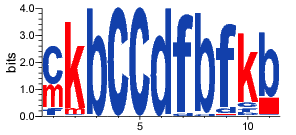

In [16]:
pbx.analysis.generate_weblogo('logo.png', count_matrix,
                              residue_min=20, residue_max=30)
display(Image('logo.png'))
!rm logo.png